# WEO Economic Data Analysis & Recession Prediction

**Objective:** Load World Economic Outlook (WEO) data, clean and transform it, then use machine learning models to predict global recessions.

**Workflow:**
1. Data loading and cleaning
2. Feature engineering and recession flagging
3. Exploratory data analysis
4. Model training with full and reduced feature sets (comparing 13 vs 5 features)
5. Economy-specific analysis (Upper vs Lower economies with both feature sets)
6. Future predictions for all scenarios

**Models Used:** Logistic Regression, Random Forest, Gradient Boosting, Linear SVM, KNN, Naive Bayes, MLP, Decision Tree, and Ensemble

In [1]:
# Core data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
# Machine learning models
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    classification_report, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score,
    confusion_matrix
)

# File handling
import csv
from pathlib import Path

# Optional XGBoost
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except ImportError:
    HAS_XGB = False

# Optional pycountry for continent mapping
try:
    import pycountry
    import pycountry_convert as pc
    HAS_PYCOUNTRY = True
except ImportError:
    HAS_PYCOUNTRY = False

# 1. Data Loading

In [2]:
p = Path(r"data.csv")
if not p.exists():
    raise FileNotFoundError(p)

# Detect encoding and delimiter
encoding = "utf-8"
try:
    sample = p.read_text(encoding=encoding)[:8192]
except UnicodeDecodeError:
    encoding = "latin-1"
    sample = p.read_text(encoding=encoding)[:8192]

try:
    delim = csv.Sniffer().sniff(sample).delimiter
except Exception:
    delim = ","

df = pd.read_csv(p, sep=delim, encoding=encoding, low_memory=False, parse_dates=True)
print("Shape:", df.shape)
df.head()

Shape: (8626, 61)


,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Subject Notes,Units,Scale,Country/Series-specific Notes,1980,...,2022,2023,2024,2025,2026,2027,2028,2029,2030,Estimates Start After
0,512,AFG,NGDP_R,Afghanistan,"Gross domestic product, constant prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,032.712","1,056.123",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
1,512,AFG,NGDP_RPCH,Afghanistan,"Gross domestic product, constant prices",Annual percentages of constant price GDP are y...,Percent change,Units,"See notes for: Gross domestic product, consta...",NaN,...,-6.240,2.267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
2,512,AFG,NGDP,Afghanistan,"Gross domestic product, current prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,283.442","1,350.910",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
3,512,AFG,NGDPD,Afghanistan,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,14.501,17.248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
4,512,AFG,PPPGDP,Afghanistan,"Gross domestic product, current prices",These data form the basis for the country weig...,Purchasing power parity; international dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,86.149,91.272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0


In [3]:
print(f"Number of columns: {df.shape[1]}")
print(f"Number of rows: {df.shape[0]}")
print("\nColumn names:", df.columns.tolist())

Number of columns: 61
Number of rows: 8626

Column names: ['WEO Country Code', 'ISO', 'WEO Subject Code', 'Country', 'Subject Descriptor', 'Subject Notes', 'Units', 'Scale', 'Country/Series-specific Notes', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', 'Estimates Start After']


# 2. Data Cleaning & Transformation

## Filter to Selected Economic Indicators

In [4]:
df.drop(columns=["WEO Country Code", "ISO", "Country/Series-specific Notes", "Subject Notes", 
                 "Units", "Scale", "Estimates Start After", "Subject Descriptor"], inplace=True)

codes = {"NGSD_NGDP", "NGDPRPC", "PCPI", "TM_RPCH", "TX_RPCH", "LP", "GGR_NGDP", "GGX_NGDP", 
         "GGXCNL_NGDP", "GGSB_NPGDP", "GGXONLB_NGDP", "GGXWDN_NGDP", "BCA_NGDPD"}
col = "WEO Subject Code"

if col not in df.columns:
    raise KeyError(f"Column {col!r} not found in dataframe")

df = df[df[col].astype(str).str.strip().isin(codes)].copy()
print("shape after filter:", df.shape)
df

shape after filter: (2548, 53)


,WEO Subject Code,Country,1980,1981,1982,1983,1984,1985,1986,1987,...,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
6,NGDPRPC,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"27,467.825","25,101.133","25,044.069",NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NGSD_NGDP,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.931,-1.863,-5.062,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,PCPI,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,130.038,143.822,132.728,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,TM_RPCH,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-30.012,29.820,14.971,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,TX_RPCH,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.529,30.217,-2.680,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8612,GGXCNL_NGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-3.225,-4.877,-5.320,-2.060,-0.504,0.441,0.886,0.996,1.134,1.166
8614,GGSB_NPGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8616,GGXONLB_NGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.573,-4.695,-5.198,-1.096,0.537,1.529,1.948,2.028,2.108,2.108
8618,GGXWDN_NGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Reshaping: Wide to Long to Wide

In [5]:
year_cols = df.columns[2:]

df[year_cols] = df[year_cols].replace({',': ''}, regex=True)
df[year_cols] = df[year_cols].apply(pd.to_numeric, errors="coerce")

df["Country"] = (
    df["Country"]
    .str.replace(" ", "_")
    .str.replace("'", "")
    .str.replace("-", "_")
)

df_long = df.melt(id_vars=["WEO Subject Code", "Country"],
                  var_name="Year", value_name="Value")

df_long["Year"] = df_long["Year"].astype(str).str.strip()
df_long = df_long[df_long["Year"].str.fullmatch(r"\d{4}")].copy()
df_long["Year"] = df_long["Year"].astype(int)

df_long["Value"] = (
    df_long["Value"].astype(str)
    .str.replace(",", "")
    .replace({"": None, "nan": None})
    .astype(float)
)

df_pivot = df_long.pivot_table(
    index=["Country", "Year"],
    columns="WEO Subject Code",
    values="Value",
    aggfunc="first"
).reset_index()

df_pivot.columns.name = None
df_pivot = df_pivot.set_index("Year")

df_pivot

,Country,BCA_NGDPD,GGR_NGDP,GGSB_NPGDP,GGXCNL_NGDP,GGXONLB_NGDP,GGXWDN_NGDP,GGX_NGDP,LP,NGDPRPC,NGSD_NGDP,PCPI,TM_RPCH,TX_RPCH
Year,,,,,,,,,,,,,,
2002,Afghanistan,33.908,6.845,NaN,-0.098,NaN,NaN,6.943,21.000,21594.230,61.151,31.263,NaN,NaN
2003,Afghanistan,29.616,9.826,NaN,-2.102,NaN,NaN,11.927,22.645,21766.381,59.718,42.413,36.222,49.541
2004,Afghanistan,37.216,12.676,NaN,-2.393,NaN,NaN,15.069,23.554,21067.277,72.570,49.351,-0.427,-8.436
2005,Afghanistan,30.226,14.733,NaN,-0.917,-0.870,NaN,15.651,24.411,22731.779,67.274,54.566,55.010,41.968
2006,Afghanistan,20.844,18.946,NaN,0.684,0.724,NaN,18.262,25.443,22979.189,50.333,58.269,-2.198,-6.919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026,Zimbabwe,3.063,18.698,NaN,0.441,1.529,NaN,18.257,17.729,6.061,NaN,1204688.561,NaN,NaN
2027,Zimbabwe,2.927,19.117,NaN,0.886,1.948,NaN,18.231,18.104,6.150,NaN,1300690.916,NaN,NaN
2028,Zimbabwe,2.895,19.197,NaN,0.996,2.028,NaN,18.201,18.488,6.231,NaN,1404343.758,NaN,NaN


# 3. Feature Engineering

## Add Recession Target Variable

In [6]:
global_recession_years = [
    1975, 1980, 1981, 1982, 1991, 1992, 1993,
    2008, 2009, 2010, 2020, 2021
]

df_pivot["Global_Recession"] = df_pivot.index.isin(global_recession_years).astype(int)
df_pivot = df_pivot.dropna()
df_pivot

,Country,BCA_NGDPD,GGR_NGDP,GGSB_NPGDP,GGXCNL_NGDP,GGXONLB_NGDP,GGXWDN_NGDP,GGX_NGDP,LP,NGDPRPC,NGSD_NGDP,PCPI,TM_RPCH,TX_RPCH,Global_Recession
Year,,,,,,,,,,,,,,,
1990,Australia,-4.859,30.243,-0.286,-0.232,1.871,9.564,30.475,17.170,57478.994,22.988,57.450,-3.865,7.537,0
1991,Australia,-3.287,30.271,-2.047,-2.788,-0.978,12.595,33.059,17.379,56229.476,18.349,59.350,-2.597,12.923,1
1992,Australia,-3.283,29.312,-3.809,-4.745,-3.115,18.217,34.057,17.557,57101.179,19.263,59.925,6.853,6.422,1
1993,Australia,-3.036,29.412,-4.053,-4.727,-2.898,22.052,34.138,17.719,58797.715,21.103,60.975,5.161,8.375,1
1994,Australia,-4.491,29.949,-3.171,-3.793,-1.783,23.232,33.742,17.893,61063.073,21.604,62.150,14.287,7.940,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026,Uruguay,-1.662,28.217,-2.679,-2.703,-0.559,59.226,30.919,3.520,568824.277,13.455,120.333,5.311,3.505,0
2027,Uruguay,-1.826,28.169,-2.566,-2.584,-0.403,59.041,30.753,3.528,581143.025,13.186,126.028,5.100,3.432,0
2028,Uruguay,-1.875,28.160,-2.408,-2.412,-0.238,58.910,30.572,3.535,593587.737,13.073,131.862,5.022,3.371,0


## Review Remaining Countries

In [7]:
df_pivot["Country"].unique()

array(['Australia', 'Austria', 'Barbados', 'Belgium',
       'Bosnia_and_Herzegovina', 'Botswana', 'Brazil', 'Bulgaria',
       'Canada', 'Chile', 'Colombia', 'Costa_Rica', 'Croatia', 'Cyprus',
       'Czech_Republic', 'Denmark', 'Dominican_Republic', 'Egypt',
       'Estonia', 'Finland', 'France', 'Germany', 'Guyana', 'Hungary',
       'Iceland', 'Indonesia', 'Ireland', 'Israel', 'Italy', 'Japan',
       'Jordan', 'Kazakhstan', 'Korea', 'Latvia', 'Lebanon', 'Lithuania',
       'Luxembourg', 'Malta', 'Mexico', 'Morocco', 'Netherlands',
       'New_Zealand', 'Norway', 'Panama', 'Paraguay', 'Peru', 'Poland',
       'Portugal', 'Romania', 'Serbia', 'Slovak_Republic', 'Slovenia',
       'South_Africa', 'Spain', 'Sweden', 'Switzerland', 'Türkiye',
       'United_Kingdom', 'United_States', 'Uruguay'], dtype=object)

## Split Training and Prediction Data

In [8]:
df_predict = df_pivot.loc[df_pivot.index > 2024]
df_predict_original = df_predict.copy()
df_predict = df_predict.drop(columns=["Global_Recession", "Country"])
df_predict

,BCA_NGDPD,GGR_NGDP,GGSB_NPGDP,GGXCNL_NGDP,GGXONLB_NGDP,GGXWDN_NGDP,GGX_NGDP,LP,NGDPRPC,NGSD_NGDP,PCPI,TM_RPCH,TX_RPCH
Year,,,,,,,,,,,,,
2025,-3.069,36.195,-3.190,-2.584,-1.430,31.816,38.779,27.448,96906.115,21.981,142.313,2.067,2.140
2026,-3.437,36.365,-2.165,-1.574,-0.433,31.515,37.939,27.777,97746.927,21.813,147.336,2.234,2.201
2027,-3.383,36.241,-1.943,-1.319,-0.246,30.691,37.561,28.111,98806.006,21.993,151.238,2.218,2.735
2028,-3.363,36.127,-2.162,-1.521,-0.496,30.186,37.648,28.448,99906.222,22.128,155.093,2.218,2.875
2029,-3.380,36.122,-2.398,-1.752,-0.743,30.102,37.874,28.789,100985.107,22.237,159.011,2.218,2.761
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026,-1.662,28.217,-2.679,-2.703,-0.559,59.226,30.919,3.520,568824.277,13.455,120.333,5.311,3.505
2027,-1.826,28.169,-2.566,-2.584,-0.403,59.041,30.753,3.528,581143.025,13.186,126.028,5.100,3.432
2028,-1.875,28.160,-2.408,-2.412,-0.238,58.910,30.572,3.535,593587.737,13.073,131.862,5.022,3.371


In [9]:
df_filtered = df_pivot.loc[df_pivot.index <= 2024]
df_filtered

,Country,BCA_NGDPD,GGR_NGDP,GGSB_NPGDP,GGXCNL_NGDP,GGXONLB_NGDP,GGXWDN_NGDP,GGX_NGDP,LP,NGDPRPC,NGSD_NGDP,PCPI,TM_RPCH,TX_RPCH,Global_Recession
Year,,,,,,,,,,,,,,,
1990,Australia,-4.859,30.243,-0.286,-0.232,1.871,9.564,30.475,17.170,57478.994,22.988,57.450,-3.865,7.537,0
1991,Australia,-3.287,30.271,-2.047,-2.788,-0.978,12.595,33.059,17.379,56229.476,18.349,59.350,-2.597,12.923,1
1992,Australia,-3.283,29.312,-3.809,-4.745,-3.115,18.217,34.057,17.557,57101.179,19.263,59.925,6.853,6.422,1
1993,Australia,-3.036,29.412,-4.053,-4.727,-2.898,22.052,34.138,17.719,58797.715,21.103,60.975,5.161,8.375,1
1994,Australia,-4.491,29.949,-3.171,-3.793,-1.783,23.232,33.742,17.893,61063.073,21.604,62.150,14.287,7.940,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,Uruguay,-0.641,28.152,-2.933,-4.663,-2.103,57.414,32.815,3.478,475035.669,15.592,83.003,-11.662,-17.842,1
2021,Uruguay,-2.433,27.601,-1.140,-2.622,-0.628,54.152,30.222,3.485,501754.120,15.763,89.436,18.358,26.180,1
2022,Uruguay,-3.789,27.475,-1.939,-2.521,-0.500,51.256,29.996,3.492,523177.770,14.866,97.580,14.019,4.006,0


# 4. Exploratory Data Analysis

## Correlation Heatmap

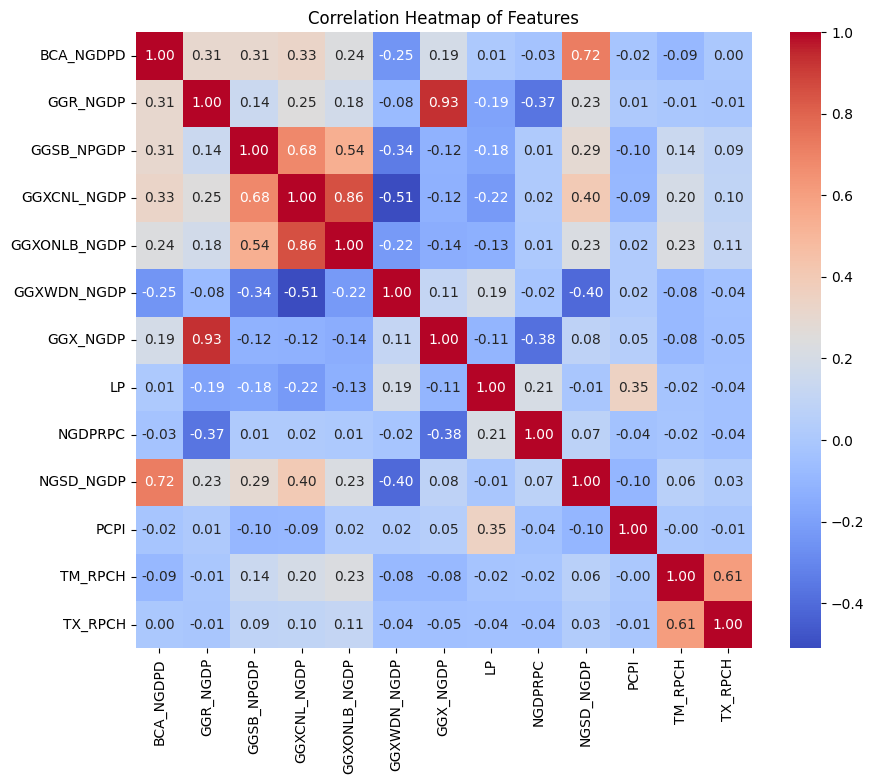

In [10]:
corr = df_filtered.drop(columns=["Country", "Global_Recession"]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap of Features")
plt.show()

## Prepare Features and Target

In [11]:
X = df_filtered.drop(columns=["Global_Recession", "Country"])
y = df_filtered["Global_Recession"]

# 5. Machine Learning Models

## Global Dataset - Full Features (13 Features)

### Define and Train All Models

In [12]:
# ============================================================
#                  TRAINING FUNCTION with SMOTE + Metrics + Confusion Matrix
# ============================================================
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
# from xgboost import XGBClassifier   # uncomment if you use XGBoost

def train_all_models(X_train, y_train, X_test, y_test, model_params=None, use_xgb=False, threshold=0.5):
    """
    Train multiple models with SMOTE, evaluate them on train/test sets,
    and return metrics including confusion matrices. Threshold can be set
    for probability-based classifiers.
    """

    # Default hyperparameters
    if model_params is None:
        model_params = {
            'logit': {
                'C': 0.2, 'penalty': 'l2', 'solver': 'lbfgs',
                'max_iter': 5000, 'random_state': 42
            },
            'rf': {
                'n_estimators': 200, 'max_depth': 4,
                'min_samples_leaf': 20, 'min_samples_split': 20,
                'max_features': 0.3, 'random_state': 42
            },
            'gb': {
                'n_estimators': 200, 'learning_rate': 0.03,
                'max_depth': 2, 'min_samples_leaf': 20,
                'subsample': 0.6, 'random_state': 42
            },
            'dt': {
                'max_depth': 3, 'min_samples_leaf': 30, 'random_state': 42
            },
            'xgb': {
                'n_estimators': 200, 'learning_rate': 0.05,
                'max_depth': 2, 'subsample': 0.7, 'colsample_bytree': 0.6,
                'reg_alpha': 0.4, 'reg_lambda': 2.0, 'random_state': 42,
                'use_label_encoder': False, 'eval_metric': 'logloss'
            }
        }

    # Train models -----------------------------------------------------
    logit = ImbPipeline([
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=42)),
        ("logit", LogisticRegression(**model_params['logit']))
    ])
    logit.fit(X_train, y_train)

    rf = ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("rf", RandomForestClassifier(**model_params['rf']))
    ])
    rf.fit(X_train, y_train)

    gb = ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("gb", GradientBoostingClassifier(**model_params['gb']))
    ])
    gb.fit(X_train, y_train)

    dt = ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("dt", DecisionTreeClassifier(**model_params['dt']))
    ])
    dt.fit(X_train, y_train)

    models = {
        "Logistic Regression": logit,
        "Random Forest": rf,
        "Gradient Boosting": gb,
        "Decision Tree": dt,
    }

    # XGBoost optional
    if use_xgb:
        xgb = ImbPipeline([
            ("smote", SMOTE(random_state=42)),
            ("xgb", XGBClassifier(**model_params['xgb']))
        ])
        xgb.fit(X_train, y_train)
        models["XGBoost"] = xgb

    # Ensemble (soft voting only)
    ensemble_estimators = [
        ("logit", logit.named_steps["logit"]),
        ("rf", rf.named_steps["rf"]),
        ("gb", gb.named_steps["gb"])
    ]
    if use_xgb:
        ensemble_estimators.append(("xgb", xgb.named_steps["xgb"]))

    ensemble = VotingClassifier(estimators=ensemble_estimators, voting="soft")
    ensemble.fit(X_train, y_train)
    models["Ensemble"] = ensemble

    # Compute metrics -----------------------------------------------------------
    results = {}
    confusion_mats = {}

    for name, m in models.items():
        if hasattr(m, "predict_proba"):
            y_pred_train = (m.predict_proba(X_train)[:, 1] >= threshold).astype(int)
            y_pred_test = (m.predict_proba(X_test)[:, 1] >= threshold).astype(int)
        else:
            y_pred_train = m.predict(X_train)
            y_pred_test = m.predict(X_test)

        results[name] = {
            "Train Accuracy": accuracy_score(y_train, y_pred_train),
            "Test Accuracy": accuracy_score(y_test, y_pred_test),
            "Precision": precision_score(y_test, y_pred_test, zero_division=0),
            "Recall": recall_score(y_test, y_pred_test, zero_division=0),
            "F1": f1_score(y_test, y_pred_test, zero_division=0)
        }

        confusion_mats[name] = confusion_matrix(y_test, y_pred_test)

    results_df = pd.DataFrame(results).T
    return models, results_df, confusion_mats


# ============================================================
#             FEATURE IMPORTANCE PLOTTING
# ============================================================
def plot_feature_importance(models, feature_names, title_prefix=""):
    logit = models.get("Logistic Regression")
    rf = models.get("Random Forest")
    gb = models.get("Gradient Boosting")
    dt = models.get("Decision Tree")

    coef = logit.named_steps['logit'].coef_[0]
    logit_importance = pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": coef,
        "Abs_Importance": np.abs(coef)
    }).sort_values("Abs_Importance")

    rf_importance = pd.DataFrame({
        "Feature": feature_names,
        "Importance": rf.named_steps['rf'].feature_importances_
    }).sort_values("Importance")

    gb_importance = pd.DataFrame({
        "Feature": feature_names,
        "Importance": gb.named_steps['gb'].feature_importances_
    }).sort_values("Importance")

    dt_importance = pd.DataFrame({
        "Feature": feature_names,
        "Importance": dt.named_steps['dt'].feature_importances_
    }).sort_values("Importance")

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes[0, 0].barh(logit_importance["Feature"], logit_importance["Coefficient"])
    axes[0, 0].set_title(f"{title_prefix}Logistic Regression")

    axes[0, 1].barh(rf_importance["Feature"], rf_importance["Importance"])
    axes[0, 1].set_title(f"{title_prefix}Random Forest")

    axes[1, 0].barh(gb_importance["Feature"], gb_importance["Importance"])
    axes[1, 0].set_title(f"{title_prefix}Gradient Boosting")

    axes[1, 1].barh(dt_importance["Feature"], dt_importance["Importance"])
    axes[1, 1].set_title(f"{title_prefix}Decision Tree")

    plt.tight_layout()
    plt.show()


# ============================================================
#                  PREDICTION FUNCTION
# ============================================================
def make_predictions(models, df_predict, use_threshold=True, threshold=0.20):
    """
    Return predictions from every model in one dataframe.
    """
    predictions = {}
    for name, model in models.items():
        if use_threshold and hasattr(model, 'predict_proba'):
            proba = model.predict_proba(df_predict)[:, 1]
            predictions[name] = (proba >= threshold).astype(int)
        else:
            predictions[name] = model.predict(df_predict)
    return pd.DataFrame(predictions, index=df_predict.index)


# ============================================================
#             CONFUSION MATRIX DISPLAY FUNCTION (with metrics)
# ============================================================
def show_confusion_matrices(confusion_mats, results_df, threshold=0.5):
    """
    Display confusion matrices for all models side by side,
    with Precision, Recall, and F1 shown under each matrix.
    """
    import matplotlib.pyplot as plt
    from sklearn.metrics import ConfusionMatrixDisplay

    n_models = len(confusion_mats)
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 5))

    if n_models == 1:
        axes = [axes]

    for ax, (name, cm) in zip(axes, confusion_mats.items()):
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap="Blues", ax=ax, colorbar=False)

        # Extract metrics from results_df
        precision = results_df.loc[name, "Precision"]
        recall = results_df.loc[name, "Recall"]
        f1 = results_df.loc[name, "F1"]

        ax.set_title(f"{name}\n(threshold={threshold})")
        ax.set_xlabel(f"Precision={precision:.2f}, Recall={recall:.2f}, F1={f1:.2f}")

    plt.tight_layout()
    plt.show()


### Train-Test Split

In [13]:
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [ ]:
models, summary_df, confusion_mats = train_all_models(X_train, y_train, X_test, y_test)
print(summary_df)
print(confusion_mats["Ensemble"])  # example: confusion matrix for ensemble


In [ ]:
plot_feature_importance(models, X_train.columns.tolist())

In [ ]:
predictions = make_predictions(models, df_predict)
print(predictions.head())

In [ ]:
show_confusion_matrices(confusion_mats, threshold=0.5)


### Model Performance Summary

In [ ]:
selected_features = ['TM_RPCH', 'GGXONLB_NGDP', 'TX_RPCH', 'GGXCNL_NGDP', 'PCPI']
X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]

# Unpack all three return values
models_reduced, summary_df_reduced, confusion_mats_reduced = train_all_models(
    X_train_reduced, y_train, X_test_reduced, y_test, threshold=0.5
)

# Show metrics table
print(summary_df_reduced)


In [ ]:
# Plot feature importance
plot_feature_importance(models_reduced, feature_names=selected_features, title_prefix="Reduced Features - ")


In [ ]:
# Predictions on restricted df
df_predict_restricted = df_predict[selected_features]
predictions_restricted = make_predictions(models_reduced, df_predict_restricted, threshold=0.5)
print(predictions_restricted)


In [ ]:

# Show confusion matrices (all in one window)
show_confusion_matrices(confusion_mats_reduced, threshold=0.5)

### Generate Predictions for Future Years

In [ ]:
# Map countries to continents (same logic as before)
try:
    import pycountry
    import pycountry_convert as pc
    
    def country_to_continent(name):
        try:
            lookup_name = name.replace('_', ' ')
            country = pycountry.countries.lookup(lookup_name)
            alpha2 = country.alpha_2
            cc = pc.country_alpha2_to_continent_code(alpha2)
            continent_map = {
                'AF': 'Africa',
                'AS': 'Asia',
                'EU': 'Europe',
                'NA': 'North_America',
                'OC': 'Oceania',
                'SA': 'South_America'
            }
            return continent_map.get(cc, 'Unknown')
        except Exception:
            return 'Unknown'
except ImportError:
    # Fallback mapping for common countries (extend as needed)
    fallback = {
        'United_States': 'North_America', 'Canada': 'North_America', 'Mexico': 'North_America',
        'China': 'Asia', 'India': 'Asia', 'Japan': 'Asia', 'Afghanistan': 'Asia',
        'Korea': 'Asia', 'Indonesia': 'Asia', 'Thailand': 'Asia', 'Vietnam': 'Asia',
        'Germany': 'Europe', 'France': 'Europe', 'United_Kingdom': 'Europe', 'Italy': 'Europe',
        'Spain': 'Europe', 'Russia': 'Europe', 'Turkey': 'Europe', 'Poland': 'Europe',
        'Brazil': 'South_America', 'Argentina': 'South_America', 'Chile': 'South_America',
        'Colombia': 'South_America', 'Peru': 'South_America', 'Venezuela': 'South_America',
        'Australia': 'Oceania', 'New_Zealand': 'Oceania',
        'South_Africa': 'Africa', 'Nigeria': 'Africa', 'Egypt': 'Africa', 'Zimbabwe': 'Africa',
        'Kenya': 'Africa', 'Ethiopia': 'Africa', 'Morocco': 'Africa',
        # Additional countries...
        'Albania': 'Europe', 'Algeria': 'Africa', 'Austria': 'Europe', 'Barbados': 'North_America',
        'Belgium': 'Europe', 'Bolivia': 'South_America', 'Bosnia_and_Herzegovina': 'Europe',
        'Bulgaria': 'Europe', 'Cabo_Verde': 'Africa', 'Costa_Rica': 'North_America',
        'Croatia': 'Europe', 'Cyprus': 'Europe', 'Czech_Republic': 'Europe', 'Denmark': 'Europe',
        'Dominican_Republic': 'North_America', 'Estonia': 'Europe', 'Finland': 'Europe',
        'Hungary': 'Europe', 'Iceland': 'Europe', 'Ireland': 'Europe',
        'Islamic_Republic_of_Iran': 'Asia', 'Israel': 'Asia', 'Jordan': 'Asia',
        'Kazakhstan': 'Asia', 'Latvia': 'Europe', 'Lebanon': 'Asia', 'Lithuania': 'Europe',
        'Luxembourg': 'Europe', 'Malta': 'Europe', 'Netherlands': 'Europe',
        'North_Macedonia': 'Europe', 'Norway': 'Europe', 'Pakistan': 'Asia',
        'Panama': 'North_America', 'Paraguay': 'South_America', 'Portugal': 'Europe',
        'Romania': 'Europe', 'Saudi_Arabia': 'Asia', 'Serbia': 'Europe', 'Seychelles': 'Africa',
        'Slovak_Republic': 'Europe', 'Slovenia': 'Europe', 'Sweden': 'Europe',
        'Switzerland': 'Europe', 'Syria': 'Asia', 'Taiwan_Province_of_China': 'Asia',
        'Trinidad_and_Tobago': 'North_America', 'Türkiye': 'Europe', 'Uruguay': 'South_America'
    }
    
    def country_to_continent(name):
        return fallback.get(name.replace(' ', '_'), 'Unknown')

# --- Add Continent column ---
df_filtered_copy = df_pivot.copy()
df_filtered_copy['Continent'] = df_filtered_copy['Country'].astype(str).apply(country_to_continent)

# --- Map continents to economy groups ---
continent_to_economy = {
    'Europe': 'Upper_Economies',
    'North_America': 'Upper_Economies',
    'Oceania': 'Upper_Economies',
    'Africa': 'Lower_Economies',
    'Asia': 'Lower_Economies',
    'South_America': 'Lower_Economies'
}

df_filtered_copy['EconomyGroup'] = df_filtered_copy['Continent'].map(continent_to_economy)

# --- Create Lower and Upper economy DataFrames ---
df_Lower_Economies = df_filtered_copy[df_filtered_copy['EconomyGroup'] == 'Lower_Economies'].drop(columns=['Continent','EconomyGroup'])
df_Upper_Economies = df_filtered_copy[df_filtered_copy['EconomyGroup'] == 'Upper_Economies'].drop(columns=['Continent','EconomyGroup'])

# --- Print summary ---
print("Created economy-specific DataFrames:")
print(f" - Lower_Economies: df_Lower_Economies (rows: {len(df_Lower_Economies)})")
print(f" - Upper_Economies: df_Upper_Economies (rows: {len(df_Upper_Economies)})")


In [ ]:
df_Lower_Economies

In [ ]:
df_Upper_Economies

## Global Dataset - Reduced Features (5 Features)

In [ ]:
df_predict_original['Continent'] = df_predict_original['Country'].astype(str).apply(country_to_continent)

continent_to_economy = {
    'Europe': 'Upper_Economies',
    'North_America': 'Upper_Economies',
    'Oceania': 'Upper_Economies',
    'Africa': 'Lower_Economies',
    'Asia': 'Lower_Economies',
    'South_America': 'Lower_Economies'
}

df_predict_original['EconomyGroup'] = df_predict_original['Continent'].map(continent_to_economy)

df_predict_lower = df_predict_original[df_predict_original['EconomyGroup'] == 'Lower_Economies'].drop(
    columns=['Continent', 'EconomyGroup', 'Country']
)
df_predict_upper = df_predict_original[df_predict_original['EconomyGroup'] == 'Upper_Economies'].drop(
    columns=['Continent', 'EconomyGroup', 'Country']
)

print("Created economy-specific prediction DataFrames from df_predict_original:")
print(f" - Lower_Economies predictions: {len(df_predict_lower)} rows")
print(f" - Upper_Economies predictions: {len(df_predict_upper)} rows")

df_predict_lower.head()
df_predict_upper.head()

# 6. Economy-Specific Analysis

## Upper Economies - Full Features

In [ ]:
# Prepare data
X = df_Upper_Economies.drop(columns=["Global_Recession", "Country"])
y = df_Upper_Economies["Global_Recession"]

split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Train models and unpack all three return values
models_upper, summary_df_upper, confusion_mats_upper = train_all_models(
    X_train, y_train, X_test, y_test, threshold=0.5
)

# Show metrics table
print(summary_df_upper)

# Plot feature importance
plot_feature_importance(models_upper, X_train.columns.tolist(), title_prefix="Upper Economies - ")

# Predictions on restricted df
X_predict_upper = df_predict_upper.drop(columns=["Global_Recession", "Country"], errors='ignore')
predictions_upper = make_predictions(models_upper, X_predict_upper, threshold=0.5)
print(predictions_upper.head())

# Show confusion matrices (all in one window)
show_confusion_matrices(confusion_mats_upper, threshold=0.5)


## Lower Economies - Full Features

In [ ]:
# Prepare data for Lower Economies
X = df_Lower_Economies.drop(columns=["Global_Recession", "Country"])
y = df_Lower_Economies["Global_Recession"]

split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Train models and unpack all three return values
models_lower, summary_df_lower, confusion_mats_lower = train_all_models(
    X_train, y_train, X_test, y_test, threshold=0.5
)

# Show metrics table
print(summary_df_lower)

# Plot feature importance
plot_feature_importance(models_lower, X_train.columns.tolist(), title_prefix="Lower Economies - ")

# Predictions on restricted df
X_predict_lower = df_predict_lower.drop(columns=["Global_Recession", "Country"], errors='ignore')
predictions_lower = make_predictions(models_lower, X_predict_lower, threshold=0.5)
print(predictions_lower.head())

# Show confusion matrices (all in one window)
show_confusion_matrices(confusion_mats_lower, threshold=0.5)


## Upper Economies - Reduced Features

In [ ]:
selected_features = ['TM_RPCH', 'GGXONLB_NGDP', 'TX_RPCH', 'GGXCNL_NGDP', 'PCPI']

X_upper = df_Upper_Economies[selected_features]
y_upper = df_Upper_Economies["Global_Recession"]

split_index_upper = int(len(X_upper) * 0.8)
X_train_upper = X_upper.iloc[:split_index_upper]
X_test_upper = X_upper.iloc[split_index_upper:]
y_train_upper = y_upper.iloc[:split_index_upper]
y_test_upper = y_upper.iloc[split_index_upper:]

# ✅ Unpack all three return values
models_upper, summary_df_upper, confusion_mats_upper = train_all_models(
    X_train_upper, y_train_upper, X_test_upper, y_test_upper, threshold=0.5
)

print("Upper Economies Accuracy (Reduced Features):")
print(summary_df_upper)

# Feature importance
plot_feature_importance(models_upper, feature_names=selected_features, 
                        title_prefix="Upper Economies - Reduced Features - ")

# Predictions
X_predict_upper_reduced = df_predict_upper[selected_features]
predictions_upper_reduced = make_predictions(models_upper, X_predict_upper_reduced, threshold=0.5)
print("Predictions for Upper Economies (Reduced Features):")
print(predictions_upper_reduced.head())

# ✅ Show confusion matrices (all in one window)
show_confusion_matrices(confusion_mats_upper, threshold=0.5)


## Lower Economies - Reduced Features

In [ ]:
X_lower = df_Lower_Economies[selected_features]
y_lower = df_Lower_Economies["Global_Recession"]

split_index_lower = int(len(X_lower) * 0.8)
X_train_lower = X_lower.iloc[:split_index_lower]
X_test_lower = X_lower.iloc[split_index_lower:]
y_train_lower = y_lower.iloc[:split_index_lower]
y_test_lower = y_lower.iloc[split_index_lower:]

# ✅ Unpack all three return values
models_lower, summary_df_lower, confusion_mats_lower = train_all_models(
    X_train_lower, y_train_lower, X_test_lower, y_test_lower, threshold=0.5
)

print("Lower Economies Accuracy (Reduced Features):")
print(summary_df_lower)

# Feature importance
plot_feature_importance(models_lower, feature_names=selected_features, 
                        title_prefix="Lower Economies - Reduced Features - ")

# Predictions
X_predict_lower_reduced = df_predict_lower[selected_features]
predictions_lower_reduced = make_predictions(models_lower, X_predict_lower_reduced, threshold=0.5)
print("Predictions for Lower Economies (Reduced Features):")
print(predictions_lower_reduced.head())

# ✅ Show confusion matrices (all in one window)
show_confusion_matrices(confusion_mats_lower, threshold=0.5)
